<h2><u>Question-5: AutoEncoder</u></h2>

<h4>1)</h4>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [ ]:
class Encoder(nn.Module):
    def __init__(self, bottleneck=128):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=bottleneck, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        x = F.relu(self.cnn1(x))
        x = F.relu(self.cnn2(x))
        x = F.relu(self.cnn3(x))
        return x

class Decoder(nn.Module):
    def __init__(self, bottleneck=128):
        super().__init__()
        self.cnnT1 = nn.ConvTranspose2d(in_channels=bottleneck, out_channels=64, kernel_size=3, stride=2)
        self.cnnT2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.cnnT3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.cnnT1(x))
        x = F.relu(self.cnnT2(x))
        x = torch.sigmoid(self.cnnT3(x))  # Sigmoid to bound the output between 0 and 1
        return x

class Autoencoder(nn.Module):
    def __init__(self, bottleneck=128):
        super().__init__()
        self.encoder = Encoder(bottleneck=128)
        self.decoder = Decoder(bottleneck=128)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 7] # last digit
train = Subset(train_dataset, train_indices)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
print(len(train))

test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
print(len(test))

6265
10000


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(bottleneck=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
model.train()

epochs = 50
for epoch in range(epochs):
    total_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/50, Loss: 0.2019
Epoch 2/50, Loss: 0.1986
Epoch 3/50, Loss: 0.1954
Epoch 4/50, Loss: 0.1923
Epoch 5/50, Loss: 0.1893
Epoch 6/50, Loss: 0.1865
Epoch 7/50, Loss: 0.1837
Epoch 8/50, Loss: 0.1810
Epoch 9/50, Loss: 0.1784
Epoch 10/50, Loss: 0.1759
Epoch 11/50, Loss: 0.1734
Epoch 12/50, Loss: 0.1711
Epoch 13/50, Loss: 0.1688
Epoch 14/50, Loss: 0.1666
Epoch 15/50, Loss: 0.1645
Epoch 16/50, Loss: 0.1624
Epoch 17/50, Loss: 0.1604
Epoch 18/50, Loss: 0.1585
Epoch 19/50, Loss: 0.1567
Epoch 20/50, Loss: 0.1549
Epoch 21/50, Loss: 0.1531
Epoch 22/50, Loss: 0.1514
Epoch 23/50, Loss: 0.1498
Epoch 24/50, Loss: 0.1482
Epoch 25/50, Loss: 0.1467
Epoch 26/50, Loss: 0.1452
Epoch 27/50, Loss: 0.1438
Epoch 28/50, Loss: 0.1424
Epoch 29/50, Loss: 0.1410
Epoch 30/50, Loss: 0.1397
Epoch 31/50, Loss: 0.1384
Epoch 32/50, Loss: 0.1372
Epoch 33/50, Loss: 0.1360
Epoch 34/50, Loss: 0.1349
Epoch 35/50, Loss: 0.1338
Epoch 36/50, Loss: 0.1327
Epoch 37/50, Loss: 0.1316
Epoch 38/50, Loss: 0.1306
Epoch 39/50, Loss: 0.

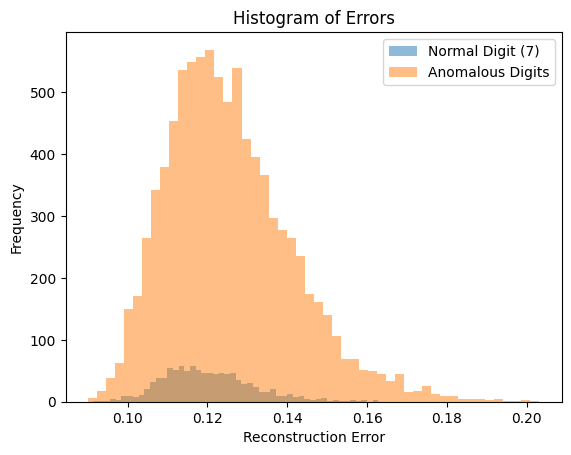

In [ ]:
model.eval()
test_errors = []
anomaly_errors = []
errors = []
test_labels = []

with torch.no_grad():
  for data, labels in test_loader:
    data = data.to(device)
    output = model(data)

    loss = torch.mean((data - output) ** 2, dim=[1,2,3])
    errors.extend(loss.cpu().numpy())

    binary_labels = (labels != 7).int().numpy() # 1 for anomaly
    test_labels.extend(binary_labels)

    for i in range(len(labels)):
        if labels[i] == 7:
            test_errors.append(loss[i].item())
        else:
            anomaly_errors.append(loss[i].item())

plt.figure()
plt.hist(test_errors, bins=50, alpha=0.5, label=f'Normal Digit (7)')
plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomalous Digits')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.legend()
plt.show()

In [ ]:
threshold = np.percentile(test_errors, 20)
print(threshold)

predictions = [1 if e > threshold else 0 for e in errors]

TP = sum(1 for p, a in zip(predictions, test_labels) if p == 1 and a == 1)
FP = sum(1 for p, a in zip(predictions, test_labels) if p == 1 and a == 0)
FN = sum(1 for p, a in zip(predictions, test_labels) if p == 0 and a == 1)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = (2 * (precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

0.11077522784471512
Precision: 0.9009
Recall: 0.8329
F1-score: 0.8656


Epoch 1/50, Loss: 0.2954
Epoch 2/50, Loss: 0.2894
Epoch 3/50, Loss: 0.2834
Epoch 4/50, Loss: 0.2776
Epoch 5/50, Loss: 0.2719
Epoch 6/50, Loss: 0.2664
Epoch 7/50, Loss: 0.2610
Epoch 8/50, Loss: 0.2558
Epoch 9/50, Loss: 0.2508
Epoch 10/50, Loss: 0.2460
Epoch 11/50, Loss: 0.2414
Epoch 12/50, Loss: 0.2369
Epoch 13/50, Loss: 0.2326
Epoch 14/50, Loss: 0.2284
Epoch 15/50, Loss: 0.2244
Epoch 16/50, Loss: 0.2204
Epoch 17/50, Loss: 0.2166
Epoch 18/50, Loss: 0.2130
Epoch 19/50, Loss: 0.2094
Epoch 20/50, Loss: 0.2059
Epoch 21/50, Loss: 0.2026
Epoch 22/50, Loss: 0.1993
Epoch 23/50, Loss: 0.1962
Epoch 24/50, Loss: 0.1931
Epoch 25/50, Loss: 0.1902
Epoch 26/50, Loss: 0.1873
Epoch 27/50, Loss: 0.1846
Epoch 28/50, Loss: 0.1819
Epoch 29/50, Loss: 0.1793
Epoch 30/50, Loss: 0.1768
Epoch 31/50, Loss: 0.1744
Epoch 32/50, Loss: 0.1720
Epoch 33/50, Loss: 0.1698
Epoch 34/50, Loss: 0.1676
Epoch 35/50, Loss: 0.1654
Epoch 36/50, Loss: 0.1634
Epoch 37/50, Loss: 0.1614
Epoch 38/50, Loss: 0.1595
Epoch 39/50, Loss: 0.

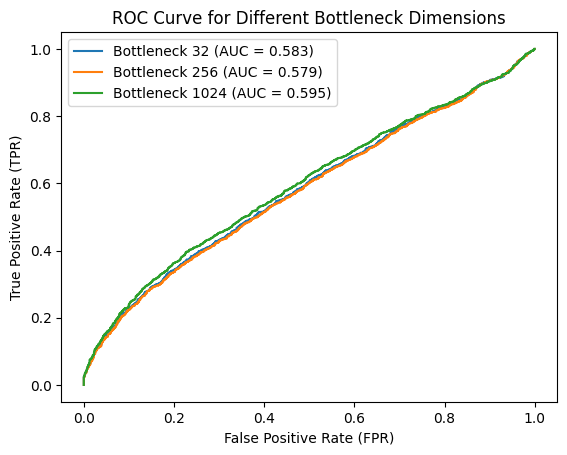

In [ ]:
bottlenecks = [32, 256, 1024]
all_errors = {}
all_labels = {}

for b in bottlenecks:
    model = Autoencoder(bottleneck=b).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    model.train()

    epochs = 50
    for epoch in range(epochs):
        total_loss = 0.0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    model.eval()
    errors = []
    test_labels = []

    with torch.no_grad():
      for data, labels in test_loader:
        data = data.to(device)
        output = model(data)

        loss = torch.mean((data - output) ** 2, dim=[1,2,3])
        errors.extend(loss.cpu().numpy())

        binary_labels = (labels != 7).int().numpy() # 1 for anomaly
        test_labels.extend(binary_labels)

    all_errors[b] = errors
    all_labels[b] = test_labels

plt.figure()
for b in bottlenecks:
    fpr, tpr, _ = roc_curve(all_labels[b], all_errors[b])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Bottleneck {b} (AUC = {roc_auc:.3f})")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Different Bottleneck Dimensions")
plt.legend()
plt.show()

<h4><u>Report</u></h4>



*   The metric values:</br>
Precision: 0.9009</br>
Recall: 0.8329</br>
F1-score: 0.8656 </br>
indicate that the model does a good job of detecting actual anomalies. The precision metric tells us that hen the model flags a sample as an anomaly, it is correct 90.09% of the time, while the high recall indicates that the model detects 83.29% of actual anomalies.
The F1-score balances both the above metrics and a high values indicates a good trade-off.
*   The AUC-ROC curve is used commonly to determine the model performance across different threshold values. The graph obtained suggests that the threshold value is very important for model performance - AUC values close of 0.5. The low AUC scores could also be because of the imbalance in the data - we have more negative samples (not the original number) than positve samples.
* Thus, though the AUC-ROC curve suggests the model does not perform well for all thresholds, the threshold chosen does give high F1-score. Also, the model performance does not drastically vary across different bottleneck sizes (though it is highest for a higher bottlenecl)

